## Underwater image enhancement model with PyTorch

This notebook contains the `Custom Dataloader`


In [1]:
import os
import torch
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Dataset HyperParams

# Dataset root
data_root = os.path.join(os.path.dirname(os.getcwd()), "Dataset", "EUVP Dataset", "Paired", "underwater_dark")

# folder phase
folder_phase = "train" # trainA and trainB

# Resize and crop
pre_process = 'resize_and_crop'

# Image Load size
load_size_ = 286

# Image Crop size
crop_size_ = 256

## Dataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):

    IMG_EXTENSIONS = [
        '.jpg', '.JPG', '.jpeg', '.JPEG',
        '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
        '.tif', '.TIF', '.tiff', '.TIFF',
    ]

    def __init__(self, dataroot, phase, max_dataset_size=float("inf"), direction = "AtoB", input_nc = 3, output_nc = 3,
                 serial_batches = True, preprocess= 'resize_and_crop', flip = True, load_size = 286, crop_size = 256):
        """
        Custom Dataset for feeding Image to the network

        :param dataroot: Root of the Dataset
        :param phase: Folder phase for Dataset
        :param max_dataset_size: Max size of the Dataset. Default: inf
        :param direction: direction of the dataflow ["AtoB" | "BtoA" ]. Default: "AtoB"
        :param input_nc: number of channels of input Image. Default: 3
        :param output_nc: number of channels of output Image. Default: 3
        :param serial_batches: Serial Batches for input. Default: 3
        :param preprocess: Type of preprocessing applied. Default: "resize_and_crop"
        :param flip: Is RandomHorizontalFlip is applied or not. Default: True
        :param load_size: Size of the image on load. Default: 286
        :param crop_size: Size of the image after resize. Default: 256
        """

        self.dataroot = dataroot
        self.phase = phase
        self.max_dataset_size = max_dataset_size
        self.direction = direction
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.serial_batches = serial_batches
        self.preprocess = preprocess
        self.flip = flip
        self.load_size = load_size
        self.crop_size = crop_size
        
        self.dir_A = os.path.join(self.dataroot, self.phase + 'A')  # create a path '/path/to/data/trainA'
        self.dir_B = os.path.join(self.dataroot, self.phase + 'B')  # create a path '/path/to/data/trainB'

        self.A_paths = sorted(self.make_dataset(self.dir_A, self.max_dataset_size))   # load images from '/path/to/data/trainA'
        self.B_paths = sorted(self.make_dataset(self.dir_B, self.max_dataset_size))    # load images from '/path/to/data/trainB'
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B
        btoA = self.direction == 'BtoA'
        input_nc = self.output_nc if btoA else self.input_nc       # get the number of channels of input image
        output_nc = self.input_nc if btoA else self.output_nc      # get the number of channels of output image
        self.transform_A = self.get_transform(grayscale=(input_nc == 1))
        self.transform_B = self.get_transform(grayscale=(output_nc == 1))
        
    def get_params(self, size):
        w, h = size
        new_h = h
        new_w = w
        if self.preprocess == 'resize_and_crop':
            new_h = new_w = self.load_size

        x = random.randint(0, np.maximum(0, new_w - self.crop_size))
        y = random.randint(0, np.maximum(0, new_h - self.crop_size))

        flip = random.random() > 0.5

        return {'crop_pos': (x, y), 'flip': flip}

    def is_image_file(self, filename):
        return any(filename.endswith(extension) for extension in self.IMG_EXTENSIONS)

    def make_dataset(self, dataset_dir, max_dataset_size=float("inf")):
        images = []
        assert os.path.isdir(dataset_dir), '%s is not a valid directory' % dir

        for root, _, fnames in sorted(os.walk(dataset_dir)):
            for fname in fnames:
                if self.is_image_file(fname):
                    path = os.path.join(root, fname)
                    images.append(path)
        return images[:min(max_dataset_size, len(images))]
    
    def get_transform(self, grayscale=False, convert=True):
        transform_list = []
        if grayscale:
            transform_list.append(transforms.Grayscale(1))

        if 'resize' in self.preprocess:
            transform_list.append(transforms.Resize([self.load_size, self.load_size]))


        if 'crop' in self.preprocess:
            transform_list.append(transforms.RandomCrop(self.crop_size))

        if not self.flip:
            transform_list.append(transforms.RandomHorizontalFlip())

        if convert:
            transform_list += [transforms.ToTensor()]
            if grayscale:
                transform_list += [transforms.Normalize((0.5,), (0.5,))]
            else:
                transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
    
    def __getitem__(self, index):
        """
        Return a data point and its metadata information.

        :param index: a random integer for data indexing
        :return: Returns a dictionary that contains A, B, A_paths and B_paths
                    A (tensor)       -- an image in the input domain
                    B (tensor)       -- its corresponding image in the target domain
                    A_paths (str)    -- image paths
                    B_paths (str)    -- image paths
        """

        
        a_path = self.A_paths[index % self.A_size]  # make sure index is within then range
        if self.serial_batches:   # make sure index is within then range
            index_b = index % self.B_size
        else:   # randomize the index for domain B to avoid fixed pairs.
            index_b = random.randint(0, self.B_size - 1)
        b_path = self.B_paths[index_b]

        # Open images
        a_img = Image.open(a_path).convert('RGB')
        b_img = Image.open(b_path).convert('RGB')

        # apply image transformation
        A = self.transform_A(a_img)
        B = self.transform_B(b_img)

        return {'A': A, 'B': B, 'A_paths': a_path, 'B_paths': b_path}
    
    def __len__(self):
        """
        As we have two datasets with potentially different number of images,
        we take a maximum of them.

        :return: the total number of images in the dataset.
        """
        
        return max(self.A_size, self.B_size)

## DataLoader

In [4]:
class CustomDatasetDataLoader:
    """Wrapper class of Dataset class that performs multi-threaded data loading"""

    def __init__(self, torch_dataset, batch_size=1, num_threads=0, serial_batches=True, max_dataset_size=float("inf")):
        """
        Custom Dataloader Function

        :param torch_dataset: Torch dataset
        :param batch_size: no of examples per batch. Default: 1
        :param num_threads: number of workers for multiprocessing. Default: 0
        :param serial_batches: Whether the dataset has serial_batches or not. Default: True
        :param max_dataset_size: Max size of the dataset.
        """
        
        self.dataset = torch_dataset
        self.batch_size = batch_size
        self.max_dataset_size = max_dataset_size
        print("dataset [%s] was created" % type(self.dataset).__name__)
        self.dataloader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size=batch_size,
            shuffle=not serial_batches,
            num_workers=int(num_threads))

    def load_data(self):
        return self

    def __len__(self):
        """Return the number of data in the dataset"""
        return min(len(self.dataset), self.max_dataset_size)

    def __iter__(self):
        """Return a batch of data"""
        for i, data in enumerate(self.dataloader):
            if i * self.batch_size >= self.max_dataset_size:
                break
            yield data

In [5]:
dataset = CustomDataset(data_root, folder_phase, preprocess=pre_process, load_size=load_size_, crop_size=crop_size_)

In [6]:
dataloader = CustomDatasetDataLoader(dataset)

dataset [CustomDataset] was created


In [7]:
i = iter(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


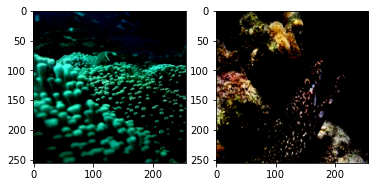

In [15]:
n = next(i)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(n['A'][0].permute(1, 2, 0))

ax[1].imshow(n['B'][0].permute(1, 2, 0))